## Import Libraries



In [ ]:
import struct
import numpy as np
from keras.layers import Conv2D,Conv1D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
from tensorflow.keras.utils import to_categorical
import tensorflow

In [ ]:
### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load yolov3 model and perform object detection
# we will use a pre-trained model to perform object detection on an unseen photograph
from numpy import expand_dims, asarray
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import cv2
import numpy as np
from tensorflow.keras import backend as K

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
from scipy.ndimage import zoom
from skimage.feature import hog
import dlib
import scipy
import matplotlib.pyplot as plt

In [ ]:
OUTPUT_FOLDER_NAME='/content/drive/MyDrive/FYP/outputs/'
X_hog_slid_img = np.load(OUTPUT_FOLDER_NAME + "hog_slide_image_1.npy").reshape(-1, 48, 48, 1)
X_imgs = np.load(OUTPUT_FOLDER_NAME + "images_1.npy")
y_new = np.load(OUTPUT_FOLDER_NAME + "labels_1.npy")
y_hot = np.load(OUTPUT_FOLDER_NAME + "labels_one_hot_1.npy")
X_new = np.load(OUTPUT_FOLDER_NAME + "image_features_1.npy")
X_hog_slid = np.load(OUTPUT_FOLDER_NAME + "hog_slide_features_1.npy").reshape(-1,2592,1)

Text(0.5, 1.0, 'Ground Truth : Sad')

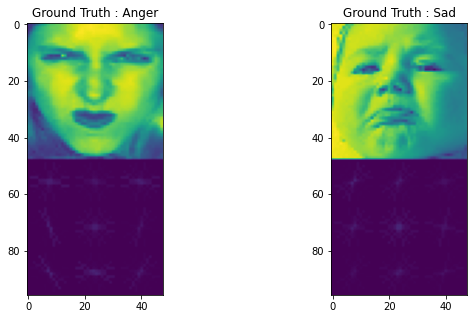

In [ ]:
def get_label(argument):
    labels = {0:'Neutral', 1:'Happy', 2:'Sad', 3:'Surprise', 4:'Fear' , 5:'Disgust', 6:'Anger', 7:'Contempt'}
    return(labels.get(argument, "Invalid emotion"))
plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(np.reshape(X_new[123],(96,48)))
plt.title("Ground Truth : {}".format(get_label(int(y_new[123]))))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(np.reshape(X_new[227],(96,48)))
plt.title("Ground Truth : {}".format(get_label(int(y_new[227]))))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_hot, test_size=0.15, random_state=42)
X_hog_train, X_hog_test, y_hog_train, y_hog_test = train_test_split(X_hog_slid, y_hot, test_size=0.15, random_state=42)

## Test pretrained models

In [ ]:
model = load_model('/content/drive/MyDrive/FYP/Models/Other/xception_model_combined_best.h5')

In [ ]:
y1 = model.predict(X_test)
model.evaluate(X_test,y_test)

58/58 [==============================] - 1s 9ms/step - loss: 1.2942 - accuracy: 0.5779


[1.2942365407943726, 0.577886700630188]

              precision    recall  f1-score   support

           0       0.45      0.78      0.57       413
           1       0.78      0.87      0.82       618
           2       0.49      0.31      0.38       187
           3       0.39      0.19      0.26       145
           4       0.51      0.41      0.46       100
           5       0.59      0.18      0.27        90
           6       0.46      0.31      0.37       187
           7       0.14      0.01      0.02        96

    accuracy                           0.58      1836
   macro avg       0.48      0.38      0.39      1836
weighted avg       0.56      0.58      0.54      1836



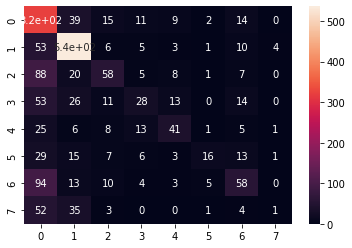

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
sns.heatmap(confusion_matrix(y_test.argmax(1), y1.argmax(1)), annot = True)
print(classification_report(y_test.argmax(1), y1.argmax(1)))

## Face Localization and Bounding box Helper functions

In [ ]:
model = load_model('/content/drive/MyDrive/FYP/model.h5')

In [ ]:
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
        
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        
        return self.score


def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [ ]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2] # 0 and 1 is row and column 13*13
    nb_box = 3 # 3 anchor boxes
    netout = netout.reshape((grid_h, grid_w, nb_box, -1)) #13*13*3 ,-1
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
    
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes


def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

#intersection over union        
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    
    
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin  
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    #Union(A,B) = A + B - Inter(A,B)
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

In [ ]:
def do_nms(boxes, nms_thresh):    #boxes from correct_yolo_boxes and  decode_netout
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [ ]:
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename) #load_img() Keras function to load the image .
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape) # target_size argument to resize the image after loading
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0  #rescale the pixel values from 0-255 to 0-1 32-bit floating point values.
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [ ]:
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import os

In [ ]:
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
    
    return v_boxes, v_labels, v_scores

In [ ]:
def get_label(argument):
    labels = {0:'Neutral', 1:'Happy', 2:'Sad', 3:'Surprise', 4:'Fear' , 5:'Disgust', 6:'Anger', 7:'Contempt'}
    return(labels.get(argument, "Invalid emotion"))

In [ ]:
# draw all results
def draw_boxes(img , box, label):
    y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
    start_point = (x1, y1) 
    # Ending coordinate
    # represents the bottom right corner of rectangle 
    end_point = (x2, y2) 
    # Red color in BGR 
    color = (0, 0, 255) 
    # Line thickness of 2 px 
    thickness = 2
    # font 
    font = cv2.FONT_HERSHEY_PLAIN 
    # fontScale 
    fontScale = 1.5
    #create the shape
    img = cv2.rectangle(img, start_point, end_point, color, thickness) 
    # draw text and score in top left corner
    text = "%s" % (get_label(label))
    img = cv2.putText(img, text, (x1,y1), font,  
                fontScale, color, thickness, cv2.LINE_AA)
    return img

In [ ]:
def face_crop(filename, v_boxes, v_labels, v_scores):
    img = cv2.imread(filename)
    rows, cols = img.shape[0], img.shape[1]
    shape_x=48.0
    shape_y=48.0
    faces=[]
    for i in range(len(v_boxes)):
        if (not v_boxes):
            x1,y1 = 0,0
            x2,y2 = 0,0
        else:
            box = v_boxes[i]
            y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
            cropped_image = img[y1:y2, x1:x2]
            if cropped_image.shape[0]==0 or cropped_image.shape[1]==0:
              print(cropped_image.shape,v_boxes[i],filename)
              continue
            new_extracted_face = zoom(cropped_image, (shape_x / cropped_image.shape[0],shape_y / cropped_image.shape[1],1),order=3, mode='wrap')
            #cast type float
            new_extracted_face = new_extracted_face.astype(np.float32)
            #scale
            new_extracted_face /= 255.0
            faces.append(new_extracted_face)
    return faces


## Load Model

In [ ]:
clf = keras.models.load_model('/content/drive/MyDrive/FYP/Models/xception_combined_final.h5')

## Capture Img

In [ ]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]  

# define the probability threshold for detected objects
class_threshold = 0.6

labels = ["face"]


In [ ]:
from google.colab.patches import cv2_imshow
input_h = 480
input_w = 640
def find_face(photo_filename):
  boxes = list()
  image, image_w, image_h = load_image_pixels(photo_filename, (input_h, input_w))
  yhat = model.predict(image)
  for i in range(len(yhat)):
      # decode the output of the network
      boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
      
  # correct the sizes of the bounding boxes for the shape of the image
  correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

  # suppress non-maximal boxes
  do_nms(boxes, 0.5)  #Discard all boxes with pc less or equal to 0.5

  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

  
  return v_boxes, v_labels, v_scores

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
filename = take_photo()
print('Saved to {}'.format(filename))

<IPython.core.display.Javascript object>

Saved to photo.jpg


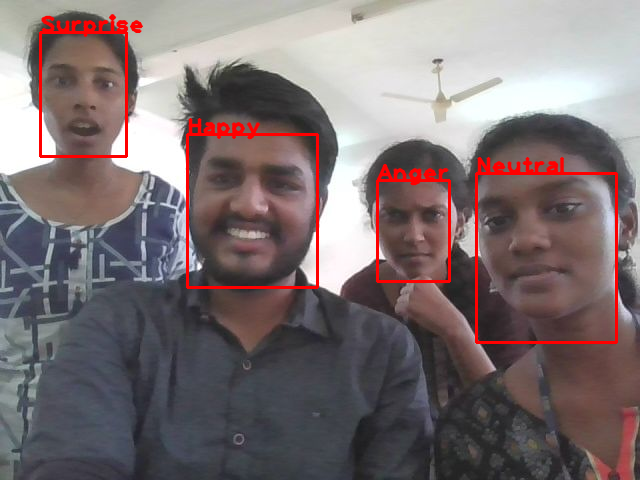

In [ ]:
img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
v_boxes, v_labels, v_scores = find_face(filename)
img=cv2.imread(filename)
if len(v_boxes):
  for i in range(len(v_boxes)):
    if (not v_boxes):
      x1,y1 = 0,0
      x2,y2 = 0,0
    else:
      box = v_boxes[i]
      y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
      cropped_image = img[y1:y2, x1:x2]
      if cropped_image.shape[0]==0 or cropped_image.shape[1]==0:
        print(cropped_image.shape,v_boxes[i],filename)
        continue
      face_1 = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
      new_extracted_face = zoom(face_1, (48 / cropped_image.shape[0],48 / cropped_image.shape[1]),order=3, mode='wrap')
      #cast type float
      new_extracted_face = new_extracted_face.astype(np.float32)
      new_extracted_face /= 255.0
      f, hog_image = hog(new_extracted_face, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True)
      new_combined = np.concatenate((new_extracted_face,hog_image),axis=0)
      image1 = new_combined.reshape((1,96, 48,1))
      ypred=clf.predict(image1)
      img = draw_boxes(img,box,ypred.argmax(1)[0])
cv2_imshow(img)


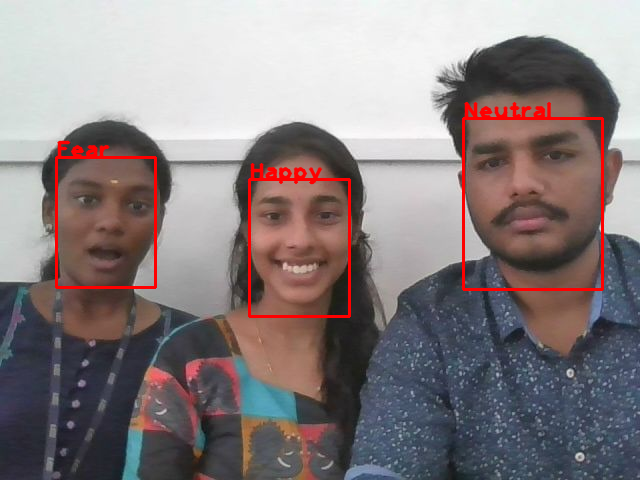

In [ ]:
for filename in ['/content/photo.jpg']:
  v_boxes, v_labels, v_scores = find_face(filename)
  img=cv2.imread(filename)
  if len(v_boxes):
    for i in range(len(v_boxes)):
      if (not v_boxes):
        x1,y1 = 0,0
        x2,y2 = 0,0
      else:
        box = v_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        cropped_image = img[y1:y2, x1:x2]
        if cropped_image.shape[0]==0 or cropped_image.shape[1]==0:
          print(cropped_image.shape,v_boxes[i],filename)
          continue
        face_1 = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        new_extracted_face = zoom(face_1, (48 / cropped_image.shape[0],48 / cropped_image.shape[1]),order=3, mode='wrap')
        #cast type float
        new_extracted_face = new_extracted_face.astype(np.float32)
        new_extracted_face /= 255.0
        image1 = new_extracted_face.reshape((1,48, 48,1))
        ypred=clf.predict(image1)
        img = draw_boxes(img,box,ypred.argmax(1)[0])
  cv2_imshow(img)